<a href="https://colab.research.google.com/github/saikarthik3099/website/blob/master/speech_recognition_explainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
useColab=True
if useColab:
    %tensorflow_version 2.x
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechDownloader.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechGenerator.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/audioUtils.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechModels.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/requirements.txt
    !pip install -r requirements.txt

In [0]:
#%load_ext autoreload
#%autoreload 2

import librosa
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import SpeechDownloader
import SpeechGenerator
import SpeechModels

In [0]:
import audioUtils

In [0]:
audioUtils.WAV2Numpy('/content/drive/My Drive/dataset(copy)/question')

100%|██████████| 45/45 [00:53<00:00,  1.19s/it]


In [0]:
audioUtils.WAV2Numpy('/content/drive/My Drive/dataset(copy)/exclamation')
audioUtils.WAV2Numpy('/content/drive/My Drive/dataset(copy)/others')

100%|██████████| 56/56 [01:07<00:00,  1.20s/it]


In [0]:
import glob

In [0]:
basePath = '/content/drive/My Drive/dataset(copy)'
questionPath = basePath + '/question'
exclamationPath = basePath + '/exclamation'
othersPath = basePath + '/others'

In [0]:
global_listID_train = []
global_label_train = []

global_listID_test = []
global_label_test = []

In [0]:
listID_train_question = []
label_train_question = []
for f in glob.iglob(questionPath + '/train/*.npy'): #question is '1' category
  listID_train_question.append(f)
  label_train_question.append(0)
global_listID_train.extend(listID_train_question)
global_label_train.extend(label_train_question)


In [0]:
listID_train_exclamation = []
label_train_exclamation = []
for f in glob.iglob(exclamationPath + '/train/*.npy'): #exclamation is '2' category
  listID_train_exclamation.append(f)
  label_train_exclamation.append(1)
global_listID_train.extend(listID_train_exclamation)
global_label_train.extend(label_train_exclamation)

In [0]:
listID_train_others = []
label_train_others = []
for f in glob.iglob(othersPath + '/train/*.npy'): #others is '3' category
  listID_train_others.append(f)
  label_train_others.append(2)
global_listID_train.extend(listID_train_others)
global_label_train.extend(label_train_others)

In [0]:
listID_test_question = []
label_test_question = []
for f in glob.iglob(questionPath + '/test/*.npy'): #question is '1' category
  listID_test_question.append(f)
  label_test_question.append(0)
global_listID_test.extend(listID_test_question)
global_label_test.extend(label_test_question)

In [0]:
listID_test_exclamation = []
label_test_exclamation = []
for f in glob.iglob(exclamationPath + '/test/*.npy'): #exclamation is '2' category
  listID_test_exclamation.append(f)
  label_test_exclamation.append(1)
global_listID_test.extend(listID_test_exclamation)
global_label_test.extend(label_test_exclamation)

In [0]:
listID_test_others = []
label_test_others = []
for f in glob.iglob(othersPath + '/test/*.npy'): #others is '3' category
  listID_test_others.append(f)
  label_test_others.append(2)
global_listID_test.extend(listID_test_others)
global_label_test.extend(label_test_others)

In [0]:
traintWAVlabelsDict = dict(zip(global_listID_train, global_label_train))
testWAVlabelsDict = dict(zip(global_listID_test, global_label_test))

In [0]:
trainGen = SpeechGenerator.SpeechGen(global_listID_train,traintWAVlabelsDict,batch_size=5)

In [0]:
testGen  = SpeechGenerator.SpeechGen(global_listID_test,testWAVlabelsDict,batch_size=5)

In [18]:
audios, classes = testGen.__getitem__(5)
classes

array([2, 1, 2, 1, 1])

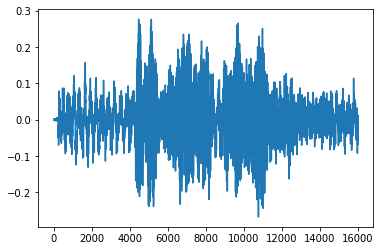

In [19]:
librosa.output.write_wav('file.wav', audios[4], 16000, norm=False)
plt.plot(audios[4])

In [20]:
from tensorflow.keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D

melspecModel = Sequential()
sr = 16000
melspecModel.add(Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, 16000),
                         padding='same', sr=sr, n_mels=80,
                         fmin=40.0, fmax=sr/2, power_melgram=1.0,
                         return_decibel_melgram=True, trainable_fb=False,
                         trainable_kernel=False,
                         name='mel_stft') )

melspecModel.add(Normalization2D(int_axis=0))

melspecModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mel_stft (Melspectrogram)    (None, 80, 125, 1)        1091664   
_________________________________________________________________
normalization2d (Normalizati (None, 80, 125, 1)        0         
Total params: 1,091,664
Trainable params: 1,091,664
Non-trainable params: 0
_________________________________________________________________


In [21]:
iLen = 16000
melspec = melspecModel.predict( audios.reshape((-1,1,iLen)) )
melspec.shape

(5, 80, 125, 1)

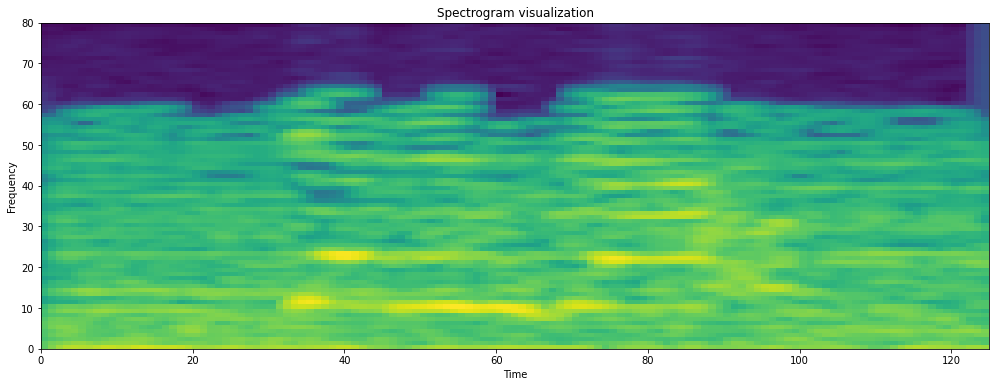

In [22]:
plt.figure(figsize=(17,6))
plt.pcolormesh(melspec[4,:,:,0])

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

In [0]:
# Check if mel spectrogram matches the one computed with librosa
librosa_melspec = librosa.feature.melspectrogram(y=audios[4], sr=sr, n_fft=1024,
                                                 hop_length=128, power=1.0, #window='hann',
                                                 n_mels=80, fmin=40.0, fmax=sr/2)
S_dB = librosa.power_to_db(librosa_melspec, ref=np.max)

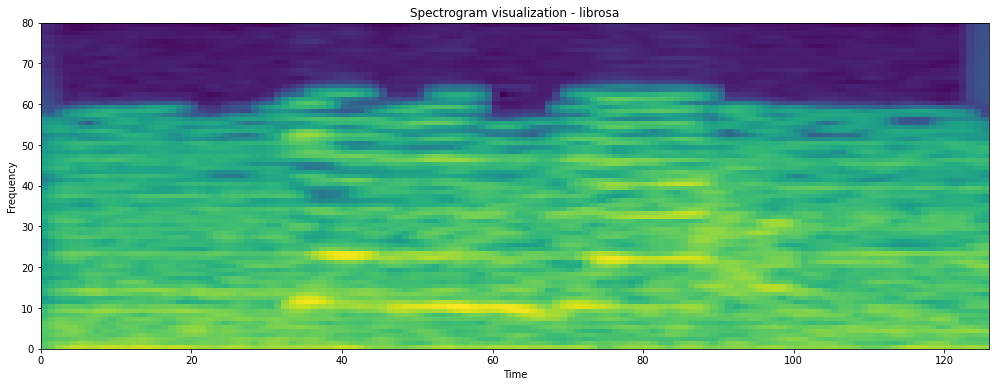

In [24]:
plt.figure(figsize=(17,6))
plt.pcolormesh(S_dB)

plt.title('Spectrogram visualization - librosa')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

In [0]:
from tensorflow.keras.models import Model, load_model

from kapre.time_frequency import Melspectrogram, Spectrogram

In [26]:
#self-attention LSTM
nCategs=3
#sr=16000
#iLen=16000
#from keras import layers as L

model = SpeechModels.AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)

model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, None)      0           input[0][0]                      
__________________________________________________________________________________________________
mel_stft (Melspectrogram)       (None, 80, None, 1)  1091664     reshape[0][0]                    
__________________________________________________________________________________________________
mel_stft_norm (Normalization2D) (None, 80, None, 1)  0           mel_stft[0][0]                   
______________________________________________________________________________________________

In [0]:
import math
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 15.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [28]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10,
                             verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint('model-attRNN.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results = model.fit(trainGen, validation_data=testGen, epochs=60, use_multiprocessing=True, workers=4, verbose=2,
                    callbacks=[earlystopper, checkpointer, lrate])

model.save('model-attRNN.h5')

Changing learning rate to 0.001
Epoch 1/60

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.48889, saving model to model-attRNN.h5
20/20 - 31s - loss: 1.0664 - sparse_categorical_accuracy: 0.4500 - val_loss: 1.0453 - val_sparse_categorical_accuracy: 0.4889 - lr: 0.0010
Changing learning rate to 0.001
Epoch 2/60

Epoch 00002: val_sparse_categorical_accuracy improved from 0.48889 to 0.51111, saving model to model-attRNN.h5
20/20 - 4s - loss: 0.9440 - sparse_categorical_accuracy: 0.5900 - val_loss: 1.0648 - val_sparse_categorical_accuracy: 0.5111 - lr: 0.0010
Changing learning rate to 0.001
Epoch 3/60

Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.51111
20/20 - 3s - loss: 0.7414 - sparse_categorical_accuracy: 0.6900 - val_loss: 1.0525 - val_sparse_categorical_accuracy: 0.4222 - lr: 0.0010
Changing learning rate to 0.001
Epoch 4/60

Epoch 00004: val_sparse_categorical_accuracy did not improve from 0.51111
20/20 - 3s - loss: 0.5945 - sparse_categor

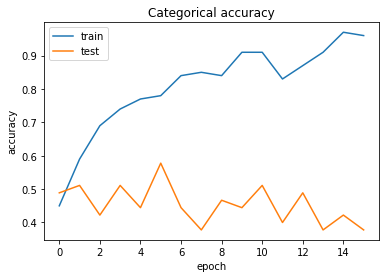

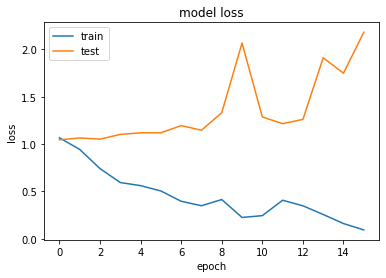

In [29]:
# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
#load best model according to cross-validation - model-attRNN
model = load_model('model-attRNN.h5', custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })

In [0]:
#read all test data
x_test, y_test = testGen.__getitem__(0)

In [32]:
valEval = model.evaluate(testGen, use_multiprocessing=False, workers=4,verbose=0)
trainEval = model.evaluate(trainGen, use_multiprocessing=False, workers=4,verbose=0)
testEval = model.evaluate(x_test, y_test, verbose=0)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nValidation: {} \nTest: {}'.format(model.metrics_names, trainEval, valEval, testEval) )

Evaluation scores: 
Metrics: ['loss', 'sparse_categorical_accuracy'] 
Train: [0.9923369884490967, 0.5199999809265137] 
Validation: [1.0877416133880615, 0.5555555820465088] 
Test: [1.5902299880981445, 0.4000000059604645]


In [0]:
attSpeechModel = Model(inputs=model.input,
                                 outputs=[model.get_layer('output').output, 
                                          model.get_layer('attSoftmax').output,
                                          model.get_layer('mel_stft').output])


In [34]:
audios, classes = testGen.__getitem__(3)
classes

array([2, 2, 2, 2, 2])

In [35]:
idAudio = 2
classes[idAudio]

2

In [0]:
outs, attW, specs = attSpeechModel.predict(audios)

In [37]:
np.argmax(outs,axis=1)

array([2, 2, 1, 2, 1])

In [38]:
specs.shape

(5, 80, 125, 1)

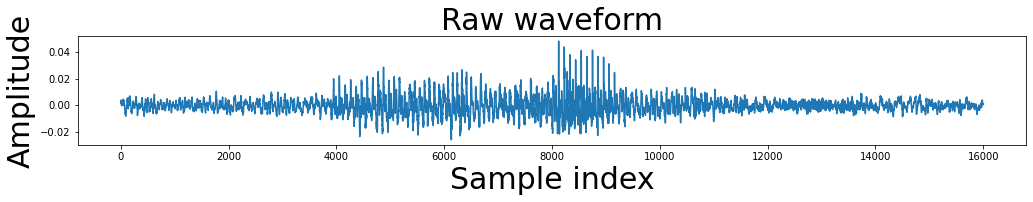

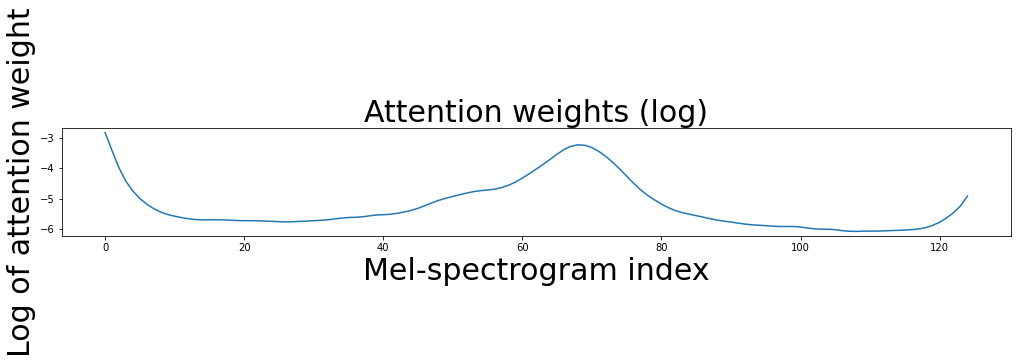

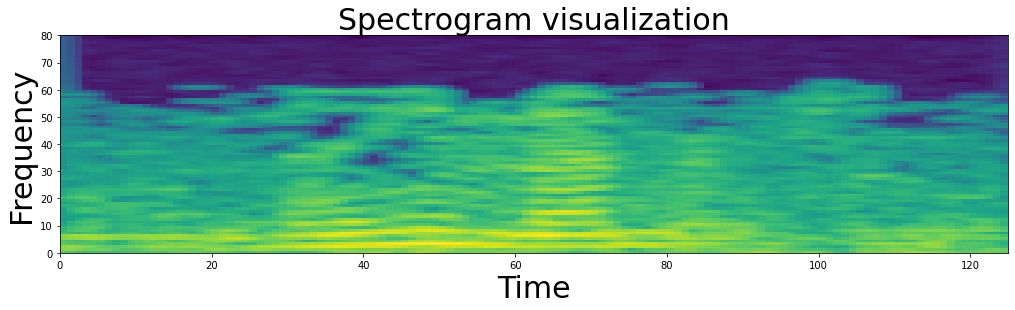

In [39]:
imgHeight = 2

plt.figure(figsize=(17,imgHeight))
plt.title('Raw waveform', fontsize=30)
plt.ylabel('Amplitude', fontsize=30)
plt.xlabel('Sample index', fontsize=30)
plt.plot(audios[idAudio])
plt.savefig('picrawWave.png', dpi = 400)
plt.show()

plt.figure(figsize=(17,imgHeight))
plt.title('Attention weights (log)', fontsize=30)
plt.ylabel('Log of attention weight', fontsize=30)
plt.xlabel('Mel-spectrogram index', fontsize=30)
plt.plot(np.log(attW[idAudio]))
plt.savefig('picAttention.png', dpi = 400)
plt.show()


plt.figure(figsize=(17,imgHeight*2))
plt.pcolormesh(specs[idAudio,:,:,0])

plt.title('Spectrogram visualization', fontsize=30)
plt.ylabel('Frequency', fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.savefig('picmelSpec.png', dpi = 400)

plt.show()

In [40]:
y_pred = model.predict(x_test, verbose=1)

1/1 [==============================] - 0s 1ms/step


In [0]:
from sklearn.metrics import confusion_matrix
import audioUtils
cm = confusion_matrix(y_test, np.argmax(y_pred,1))

In [0]:
classes = ['question','exclamation','others']

Confusion matrix, without normalization


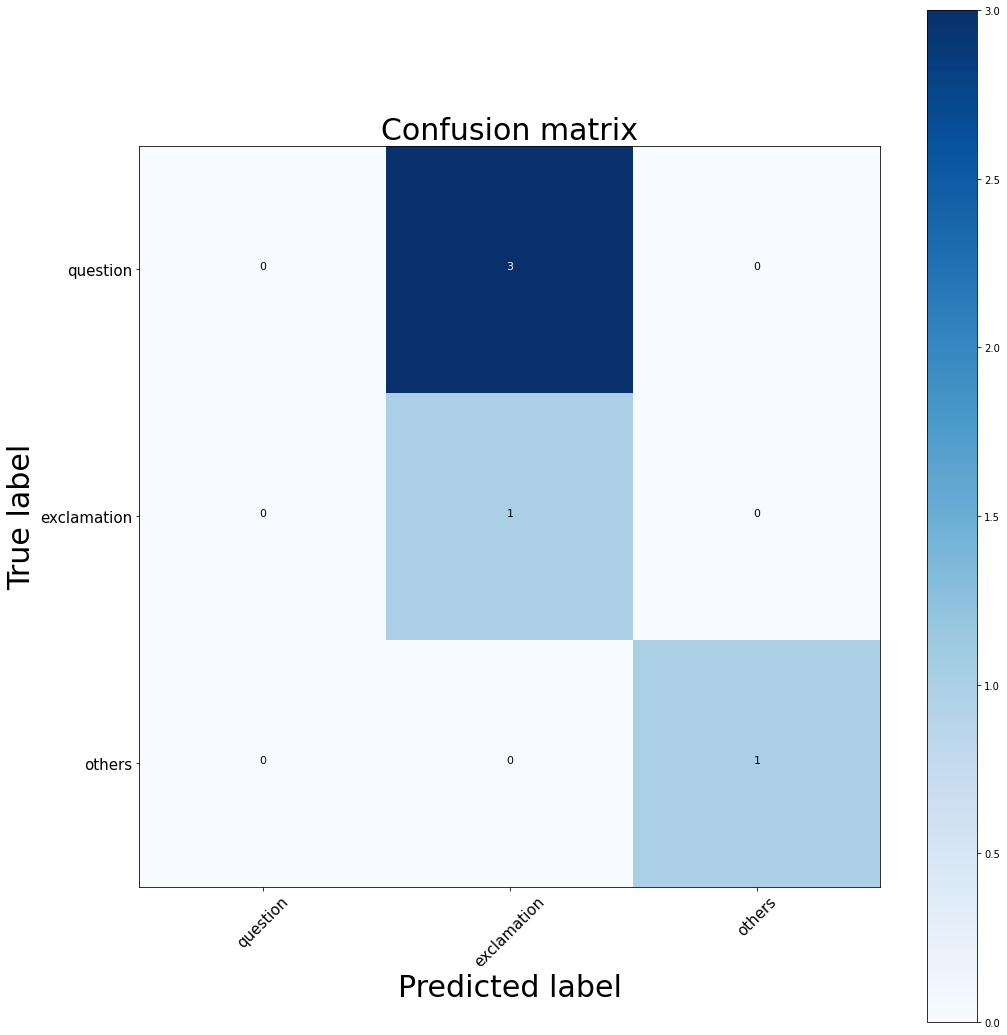

In [43]:
audioUtils.plot_confusion_matrix(cm,classes, normalize=False)